# Advanced Lane Finding Project

I will use code from camera_calibration.ipynb, color_grad_threshold.ipynb and perspective_transform.ipynb to put this main script togehther

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import pickle

%matplotlib inline

In [2]:
# Load mtx and dist data from camera_calibration.ipynb
cam_calib = pickle.load(open('./data/camera_calib.p','rb'))
mtx, dist = map(cam_calib.get, ('mtx','dist'))

In [3]:
# Load test images and apply undistortion
test_images = []    # Store test images
undist_images = []  # Store undistorted test images
# Make a list of test images
fname = glob.glob('./test_images/*.jpg')
for i, path in enumerate(fname):
    img = mpimg.imread(path)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    test_images.append(img)
    undist_images.append(undist)

In [4]:
# Transform test images to HLS and store s-Channel
sChannel_image = []
for ii in range(8):
    hls_img = cv2.cvtColor(undist_images[ii], cv2.COLOR_RGB2HLS)
    sChannel_image.append(hls_img[:,:,2])

In [5]:
# Define function for sobel X & Y threshold
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
   # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary
    return binary_output

grad_binaryx = []
grad_binaryy = []

for idx in range(8):
    grad_binaryx.append(abs_sobel_thresh(sChannel_image[idx], orient='x', thresh_min=10, thresh_max=160))
    grad_binaryy.append(abs_sobel_thresh(sChannel_image[idx], orient='y', thresh_min=10, thresh_max=160))

    #grad_binaryx2 = abs_sobel_thresh(sChannel2, orient='x', thresh_min=20, thresh_max=160)
    #grad_binaryy2 = abs_sobel_thresh(sChannel2, orient='y', thresh_min=20, thresh_max=160)

In [6]:
# Define function for magnitude threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scaled_sobel = np.max(gradmag)/255 
    gradmag = (gradmag/scaled_sobel).astype(np.uint8)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(gradmag)
    sbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary
    return binary_output

grad_binarymag = []

for idx in range(8):
    grad_binarymag.append(mag_thresh(sChannel_image[idx], sobel_kernel=3, mag_thresh=(30, 200)))


In [7]:
# Define function for direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradsobel = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(gradsobel)
    sbinary[(gradsobel >= thresh[0]) & (gradsobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary # Remove this line
    return binary_output

dir_binary = []

for idx in range(8):
    dir_binary.append(dir_threshold(sChannel_image[idx], sobel_kernel=15, thresh=(0.7, 1.3)))

In [8]:
def color_thresh01(img):
    
    # Convert to HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    lower_white = np.array([0,215,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    ## Blue Color
    #lower_blue = np.array([100,0,145], dtype=np.uint8)
    #upper_blue = np.array([200,255,200], dtype=np.uint8)
    #blue_mask  = cv2.inRange(hls, lower_blue, upper_blue)  
    
    combined_binary = np.zeros_like(white_mask)
    combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
    #combined_binary[((white_mask == 255) | (yellow_mask == 255) | (blue_mask == 255))] = 255

    combined_binary[(combined_binary == 255)] = 1
    return combined_binary

color_thresh_binary = []

for idx in range(8):
    color_thresh_binary.append(color_thresh01(undist_images[idx]))

In [9]:
# Combine Sobel X,Sobel Y, Magnitude and Direction thresholds
combine_thresh = []
#combine_thresh1 = []


for idx in range(8):
    combined = np.zeros_like(dir_binary[idx])
    #combined1 = np.zeros_like(dir_binary[idx])
    combined[((grad_binaryx[idx] == 1) & (grad_binaryy[idx] == 1))] = 1
    #combined1[((grad_binaryx[idx] == 1) & (grad_binaryy[idx] == 1)) | ((grad_binarymag[idx] == 1) & (dir_binary[idx] == 1))] = 1
    combine_thresh.append(combined)
    #combine_thresh1.append(combined1)

Perspective Combined Thresholds:


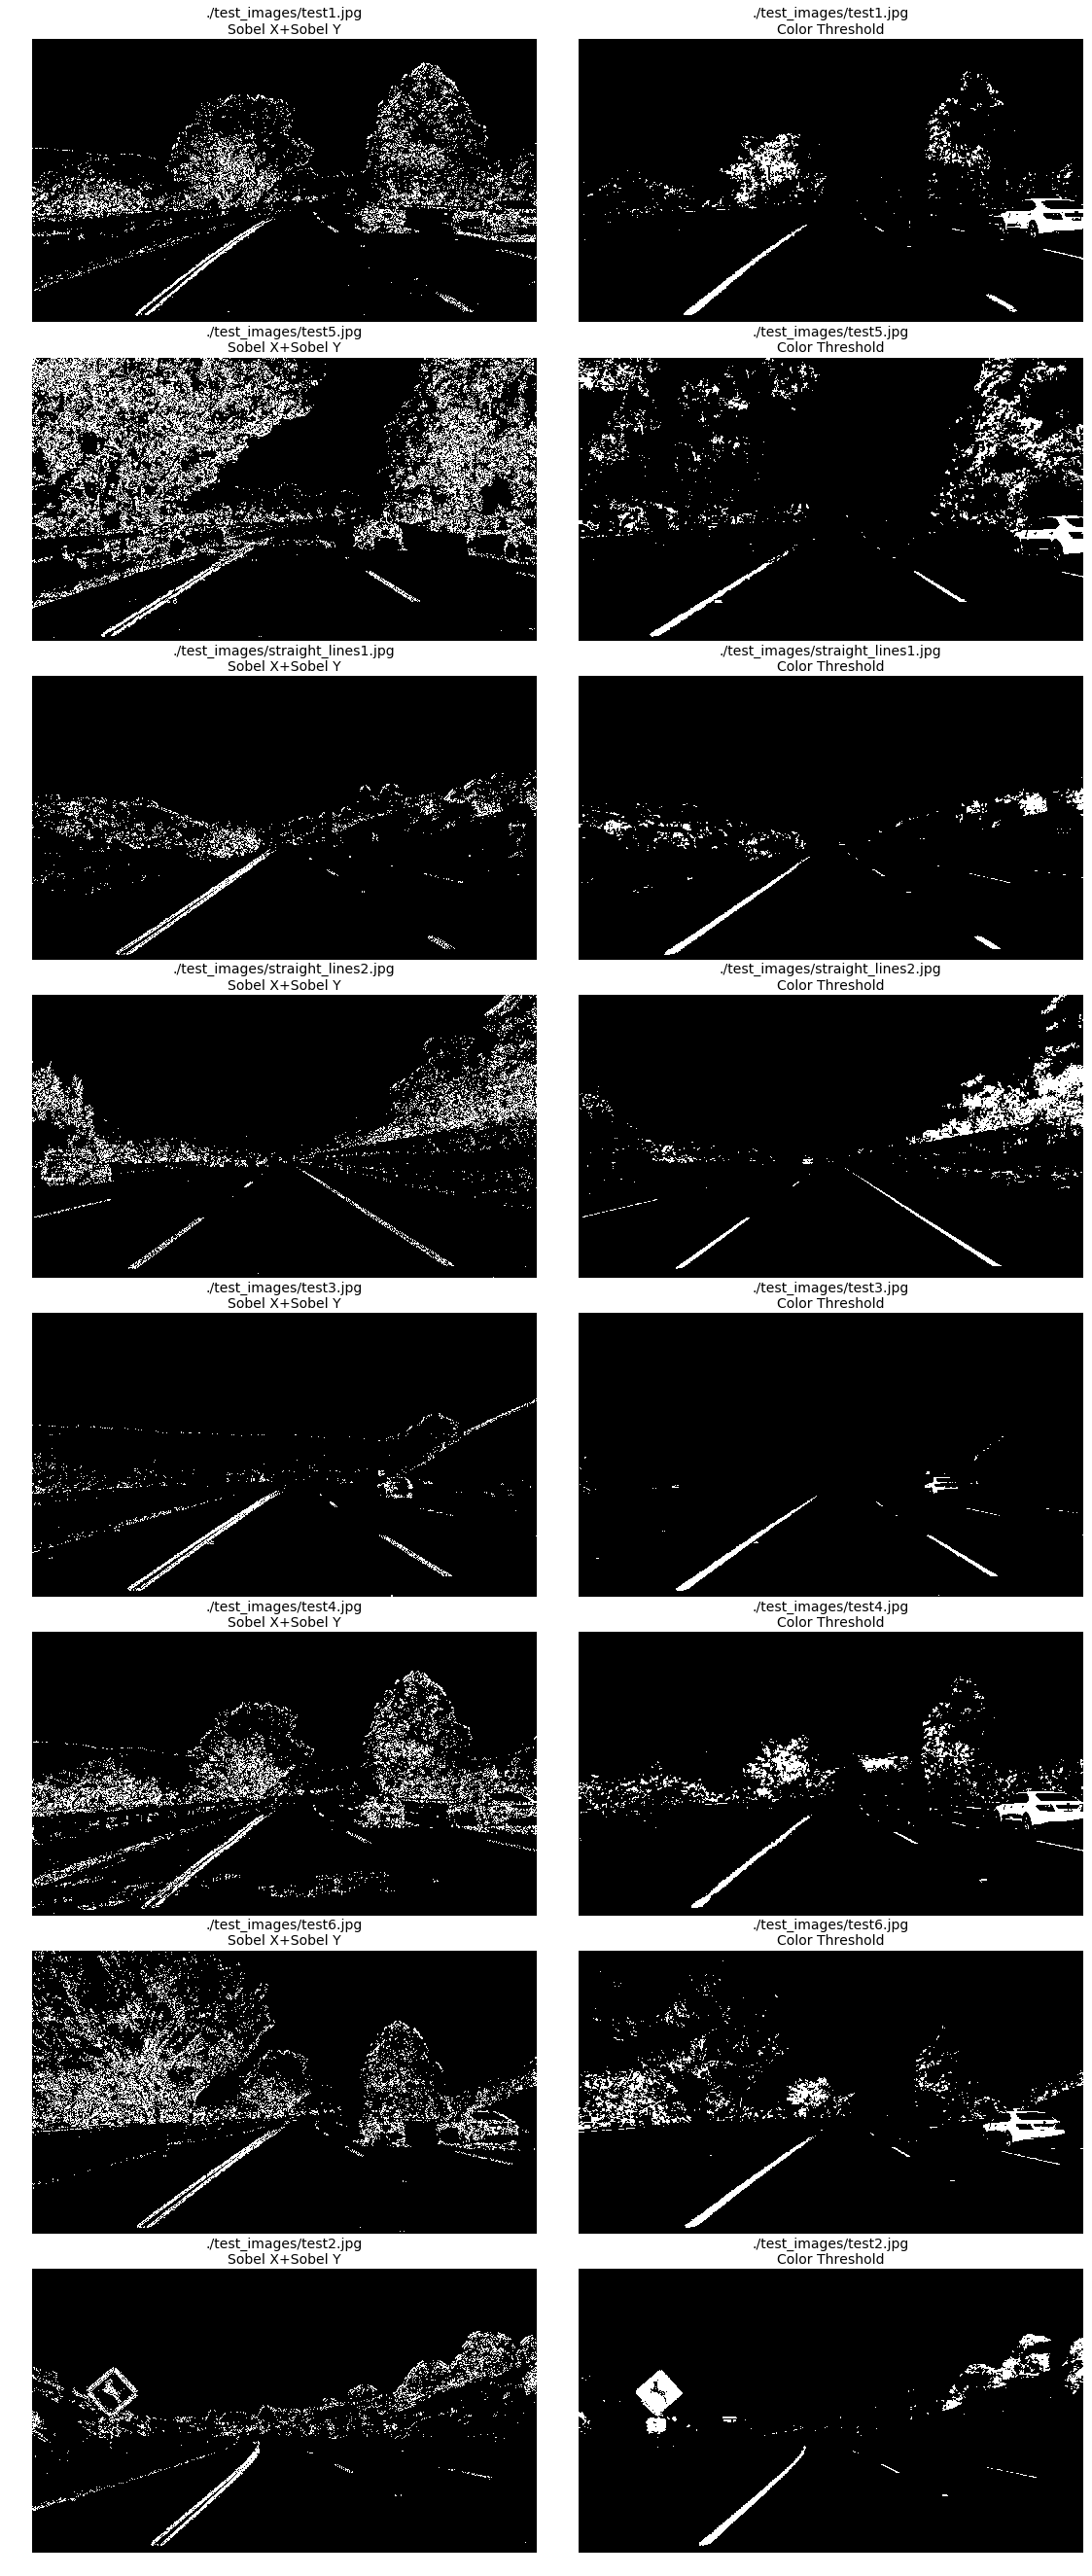

In [10]:
#title_2 = ['Sobel X+Sobel Y','Sobel X+Sobel Y+Magnitude+Direction']
title_2 = ['Sobel X+Sobel Y','Color Threshold']

img_title_compare = []
# Loop through images 
for idx in range(8):
    for jj in range(2):
        img_title_compare.append(fname[idx] + '\n' + title_2[jj])

# Compare two combined thresholds
#compare_thresh = list(zip(combine_thresh,combine_thresh1))
compare_thresh = list(zip(combine_thresh,color_thresh_binary))
flat_img1 = [item for sublist in compare_thresh for item in sublist]
print('Perspective Combined Thresholds:')
f1, ax1 = plt.subplots(8, 2, figsize=(15, 40))
f1.tight_layout()
for ax2, idx in zip(ax1.flat, range(16)):
    ax2.imshow(flat_img1[idx],cmap='gray')
    ax2.set_title(img_title_compare[idx], fontsize=14)
    ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f1.savefig('./output_images/Display_Images/compare_combined_thresholds1.jpg')

In [11]:
# Load transformation matrix for perspective transform
transformMat = pickle.load(open('./data/perspective_transform.p','rb'))
M, Minv = map(transformMat.get, ('M', 'Minv'))
#print(M)
#print(Minv)

In [12]:
# Apply perspective transform to combined thresholded binary
title_1 = ['Test','Perspective color threshold binary']
persp_trans_binary = []
img_title = []
# find image size
gray = cv2.cvtColor(undist_images[3], cv2.COLOR_RGB2GRAY)
img_size = (gray.shape[1], gray.shape[0])
# Loop through images 
for idx in range(8):
    #persp_trans_binary.append(cv2.warpPerspective(combine_thresh[idx], M, img_size))
    persp_trans_binary.append(cv2.warpPerspective(color_thresh_binary[idx], M, img_size))
    for jj in range(2):
        img_title.append(fname[idx] + '\n' + title_1[jj])

Perspective Transform Color Threshold Binary:


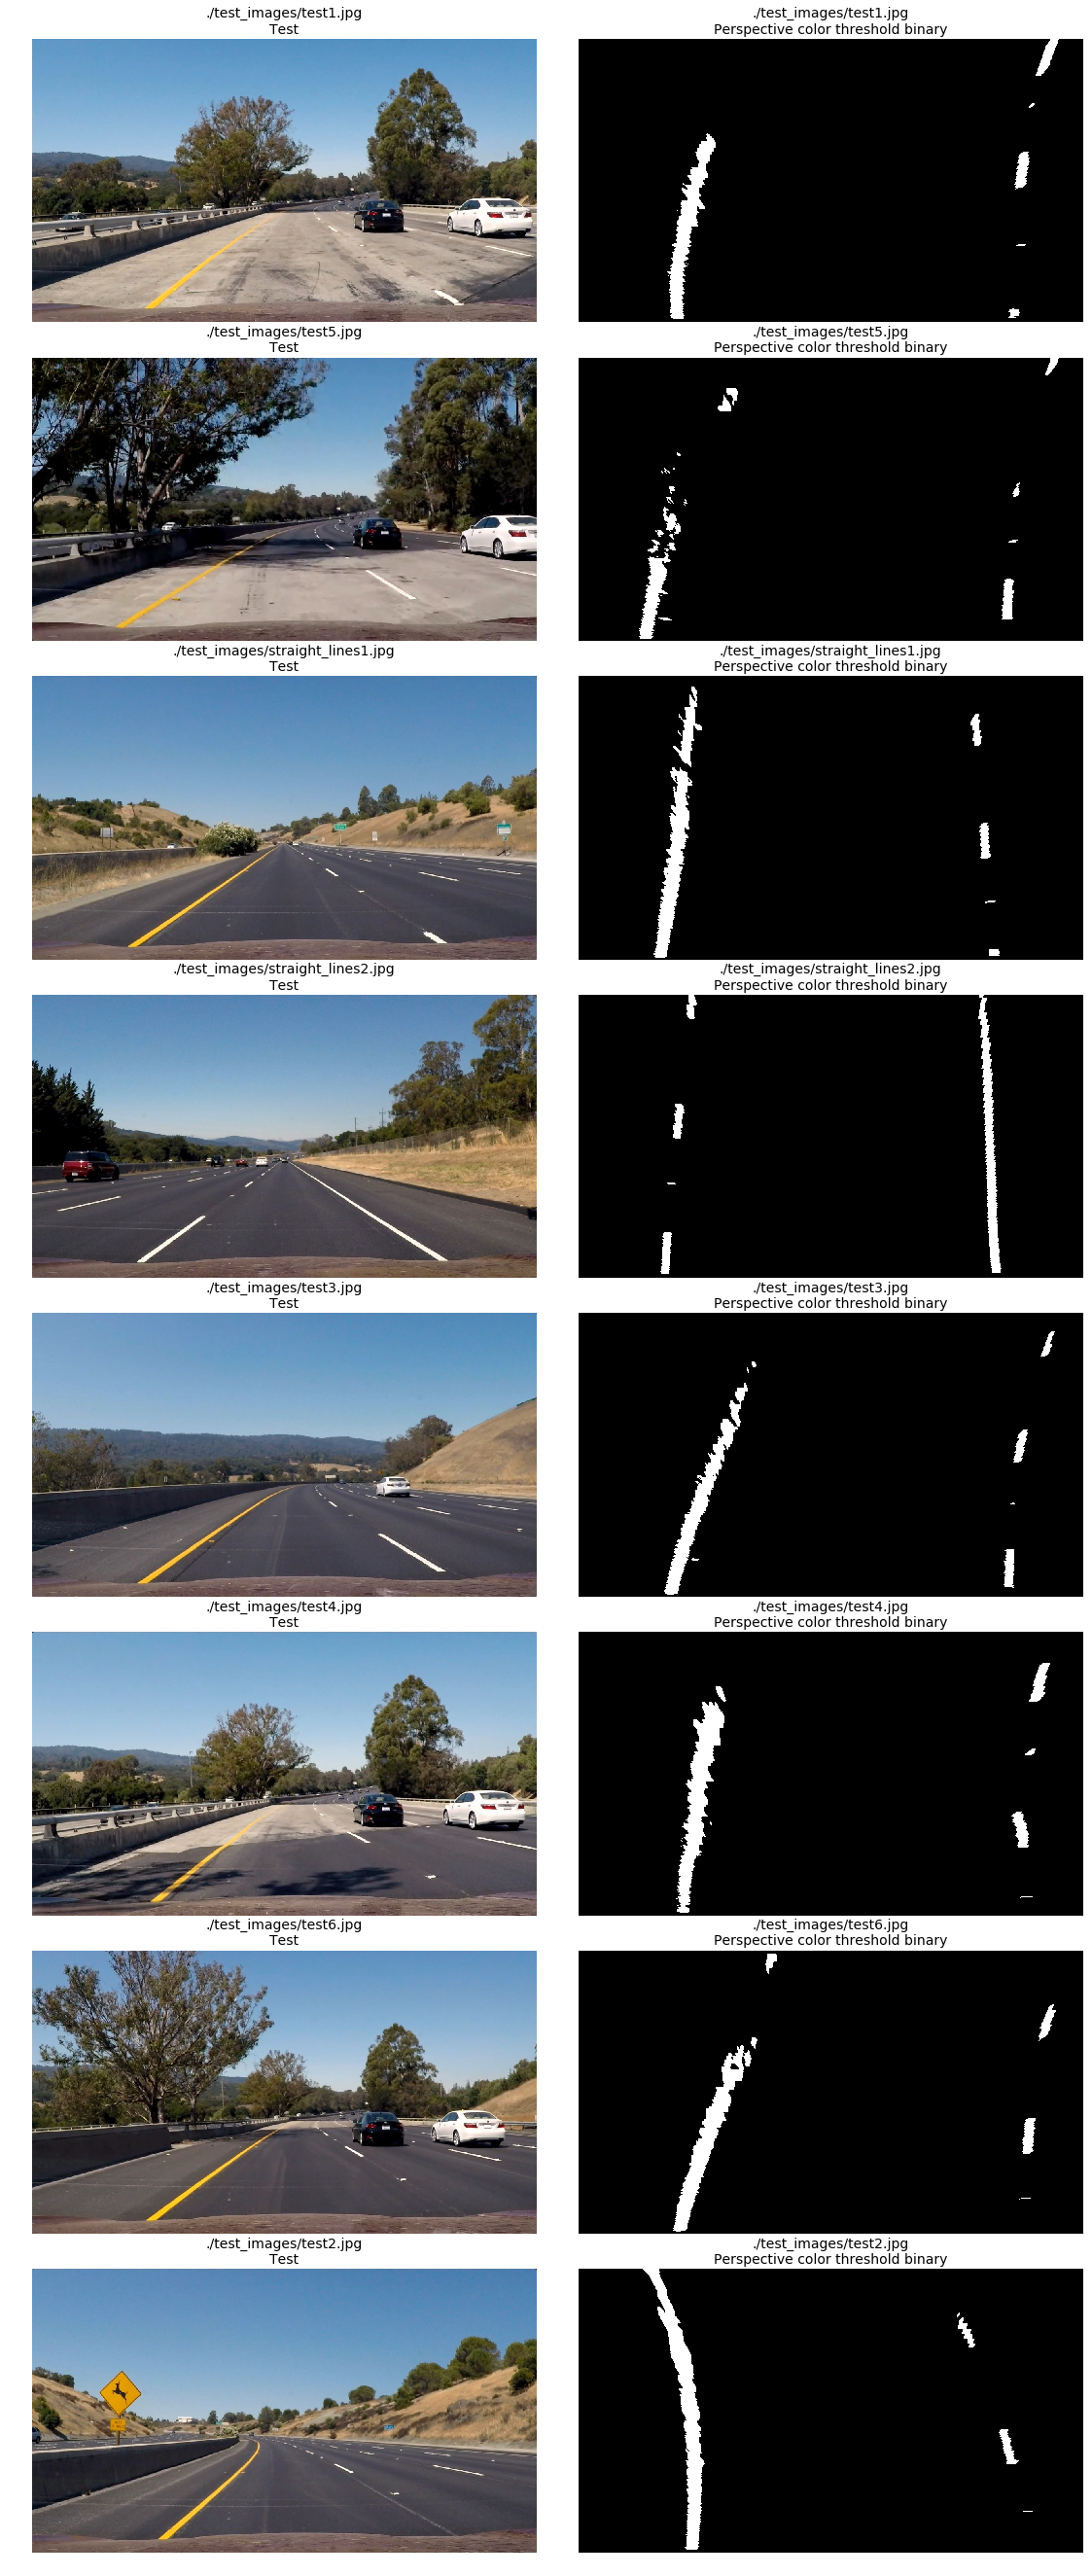

In [13]:
compare_img = list(zip(test_images,persp_trans_binary))
flat_img = [item for sublist in compare_img for item in sublist]
print('Perspective Transform Color Threshold Binary:')
f, ax = plt.subplots(8, 2, figsize=(15, 40))
f.tight_layout()
for ax1, idx in zip(ax.flat, range(16)):
    ax1.imshow(flat_img[idx],cmap='gray')
    ax1.set_title(img_title[idx], fontsize=14)
    ax1.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('./output_images/Display_Images/persp_transform_thresh_binary.jpg')

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    # histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 130 # margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 50 # minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    ## Concatenate the arrays of indices (previously was a list of lists of pixels)
    #try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #except ValueError:
        # Avoids an error if the above is not implemented fully
        #pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return left_fit_m, right_fit_m, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    left_fit_m, right_fit_m, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_pixels(binary_warped)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #print(nonzeroy)
    #print(nonzerox)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fit_m, right_fit_m, left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty


left_fit_m, right_fit_m, left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty = fit_polynomial(persp_trans_binary[1])

#plt.imshow(persp_trans_binary[1],cmap='gray')
#plt.plot(leftx, lefty, 'r.')
#plt.plot(left_fitx, ploty, color='yellow')

#plt.plot(rightx, righty, 'b.')
#plt.plot(right_fitx, ploty, color='yellow')

Test Images with lane lines identified:


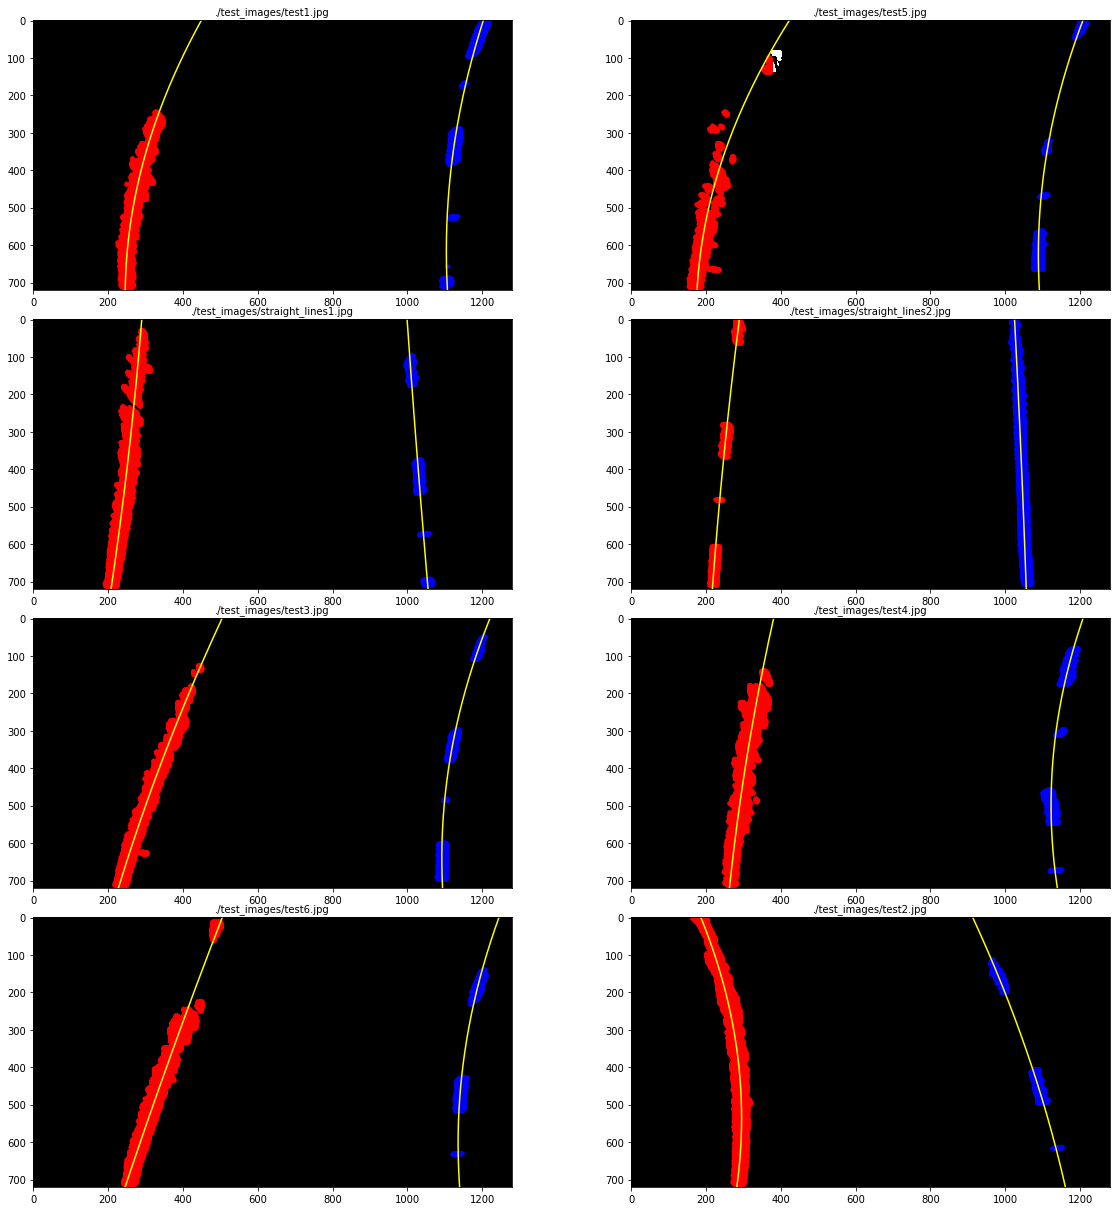

In [15]:
print('Test Images with lane lines identified:')
f, ax = plt.subplots(4, 2, figsize=(16, 18))
#print(ax)
f.tight_layout()
for ax1, idx in zip(ax.flat, range(4*2)):
    left_fit_m, right_fit_m, left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty = fit_polynomial(persp_trans_binary[idx])
    plt.sca(ax1)
    plt.imshow(persp_trans_binary[idx],cmap='gray')
    plt.plot(leftx, lefty, 'r.')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(rightx, righty, 'b.')
    plt.plot(right_fitx, ploty, color='yellow')
    ax1.set_title(fname[idx], fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('./output_images/Display_Images/lane_lines_identified.jpg')

In [16]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    return left_curverad, right_curverad

for idx in range(8):
    left_fit_m, right_fit_m, left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty = fit_polynomial(persp_trans_binary[idx])
    leftcurve, rightcurve = measure_curvature_real(ploty, left_fit_m, right_fit_m)
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(fname[idx],leftcurve,rightcurve))

Image : ./test_images/test1.jpg, Left : 439.02 km, Right : 631.27 km
Image : ./test_images/test5.jpg, Left : 410.11 km, Right : 541.39 km
Image : ./test_images/straight_lines1.jpg, Left : 3530.65 km, Right : 14626.33 km
Image : ./test_images/straight_lines2.jpg, Left : 4495.35 km, Right : 13132.10 km
Image : ./test_images/test3.jpg, Left : 1508.00 km, Right : 525.40 km
Image : ./test_images/test4.jpg, Left : 1997.20 km, Right : 479.13 km
Image : ./test_images/test6.jpg, Left : 4434.52 km, Right : 547.90 km
Image : ./test_images/test2.jpg, Left : 433.91 km, Right : 1005.04 km


In [17]:
def draw_patch(img, left_fit, right_fit):
    y_eval = img.shape[0]
    ploty = np.linspace(0, y_eval - 1, y_eval)
    color_wrap = np.zeros_like(img).astype(np.uint8)
    
    # Calculate left_fit and right_fit
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points format usable by cv2.fillPoly()
    pts_left  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_wrap, np.int_([pts]), (0, 255, 0))
    
    # Wrap the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_wrap, Minv, (img.shape[1], img.shape[0]))
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
def draw_patch_image(img):
    undist1   = cv2.undistort(img,mtx,dist,None,mtx)
    #hls_img1  = cv2.cvtColor(undist1, cv2.COLOR_RGB2HLS)
    #sChannel1 = hls_img1[:,:,2]
    #grad_binaryx1 = abs_sobel_thresh(sChannel1, orient='x', thresh_min=20, thresh_max=160)
    #grad_binaryy1 = abs_sobel_thresh(sChannel1, orient='y', thresh_min=20, thresh_max=160)
    #combined1     = np.zeros_like(grad_binaryy1)
    #combined1[((grad_binaryx1 == 1) & (grad_binaryy1 == 1))] = 1
    combined1     = color_thresh01(undist1)
    gray1         = cv2.cvtColor(undist1, cv2.COLOR_RGB2GRAY)
    img_size1     = (gray1.shape[1], gray1.shape[0])
    warped_img    = cv2.warpPerspective(combined1, M, img_size1)
    left_fit_m, right_fit_m, left_fit, right_fit, _, _, _, _, _ = find_lane_pixels(warped_img)
    output = draw_patch(img, left_fit, right_fit)
    return output

#out_img = draw_patch_image(test_images[2])
#plt.imshow(out_img)

Test Images with lane patch:


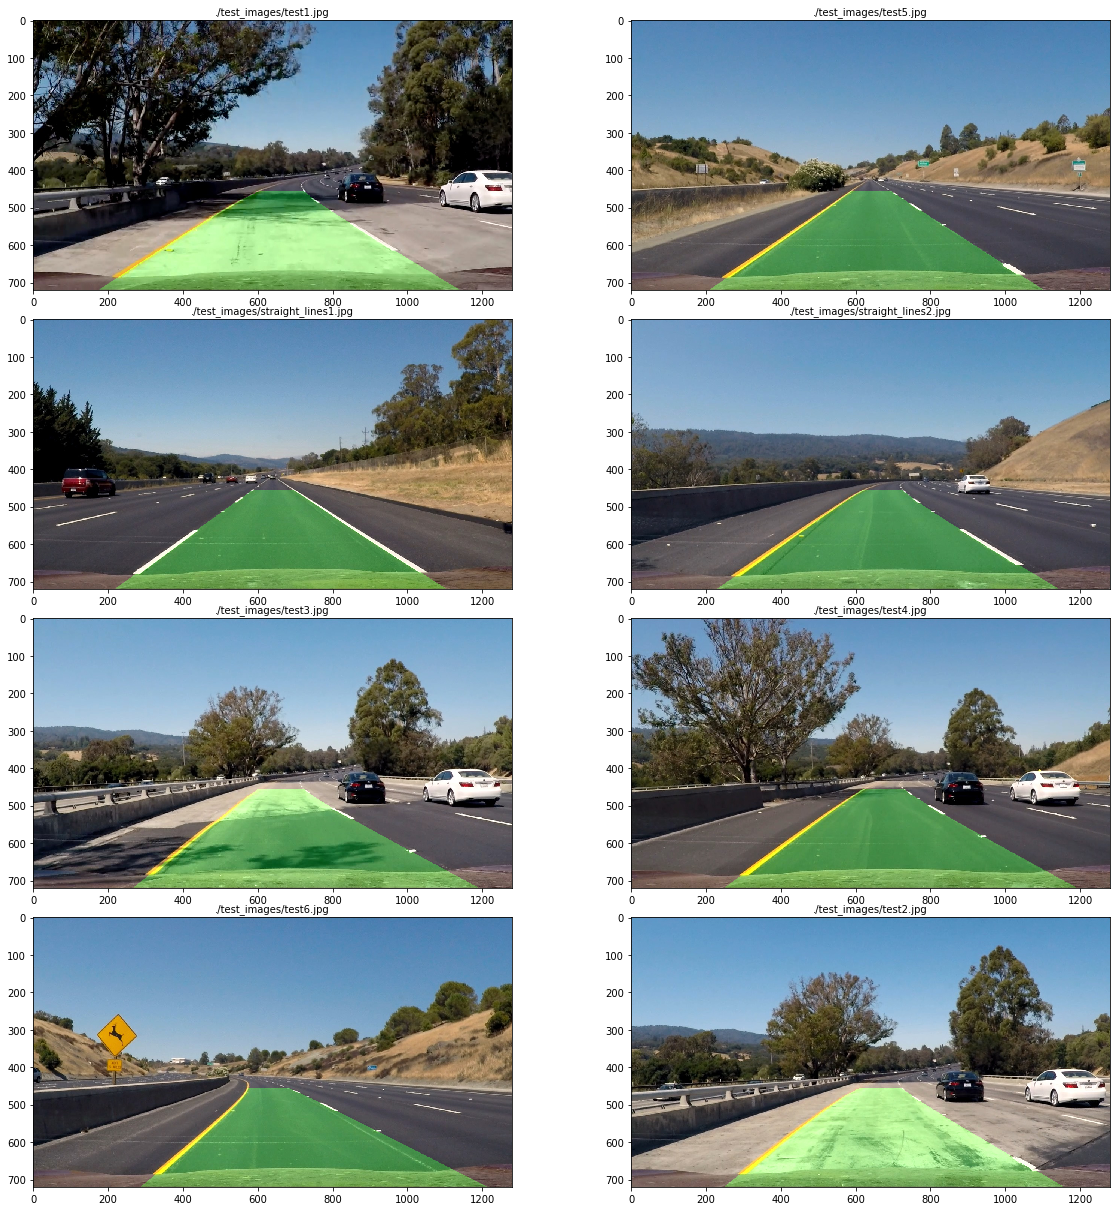

In [18]:
print('Test Images with lane patch:')
f, ax = plt.subplots(4, 2, figsize=(16, 18))
#print(ax)
f.tight_layout()
for ax1, idx in zip(ax.flat, range(4*2)):
    out_img = draw_patch_image(test_images[idx])
    plt.imshow(out_img)
    plt.sca(ax1)
    ax1.set_title(fname[idx], fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
def pic_pipeline(img):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # draw lane patch
    undist1   = cv2.undistort(img,mtx,dist,None,mtx)
    #hls_img1  = cv2.cvtColor(undist1, cv2.COLOR_RGB2HLS)
    #sChannel1 = hls_img1[:,:,2]
    #grad_binaryx1 = abs_sobel_thresh(sChannel1, orient='x', thresh_min=8, thresh_max=160)
    #grad_binaryy1 = abs_sobel_thresh(sChannel1, orient='y', thresh_min=8, thresh_max=160)
    #combined1     = np.zeros_like(grad_binaryy1)
    #combined1[((grad_binaryx1 == 1) & (grad_binaryy1 == 1))] = 1
    combined1 = color_thresh01(undist1)
    
    gray1         = cv2.cvtColor(undist1, cv2.COLOR_RGB2GRAY)
    img_size1     = (gray1.shape[1], gray1.shape[0])
    warped_img    = cv2.warpPerspective(combined1, M, img_size1)
    left_fit_m, right_fit_m, left_fit, right_fit, _, _, _, _, _ = find_lane_pixels(warped_img)
    output = draw_patch(img, left_fit, right_fit)
    
    # calculate curvature
    leftcurve, rightcurve = measure_curvature_real(ploty, left_fit_m, right_fit_m)
    
    # compute vehicle center
    xmax       = img.shape[1]*xm_per_pix
    ymax       = img.shape[0]*ym_per_pix
    veh_loc    = xmax/2
    left_line  = left_fit_m[0]*ymax**2 + left_fit_m[1]*ymax + left_fit_m[2]
    right_line = right_fit_m[0]*ymax**2 + right_fit_m[1]*ymax + right_fit_m[2]
    lane_mid   = left_line + (right_line - left_line)/2
    diff_center= lane_mid - veh_loc
    if diff_center < 0:
        text = 'left of center'
    else:
        text = 'right of center'
    
    # print text
    font      = cv2.FONT_HERSHEY_DUPLEX
    fontColor = (255, 255, 255)
    fontsize  = 2
    cv2.putText(output, 'Left Curvature: {:.0f} m'.format(leftcurve),(50,60),font, fontsize, fontColor, 2)
    cv2.putText(output, 'Right Curvature: {:.0f} m'.format(rightcurve),(50,130),font, fontsize, fontColor, 2)
    cv2.putText(output, 'Vehicle is %.2f m %s' % (np.absolute(diff_center), text),(50,200),font, fontsize, fontColor, 2)
    
    return output

#out_img = pic_pipeline(test_images[2])
#plt.imshow(out_img)

Test Images with lane patch and text:


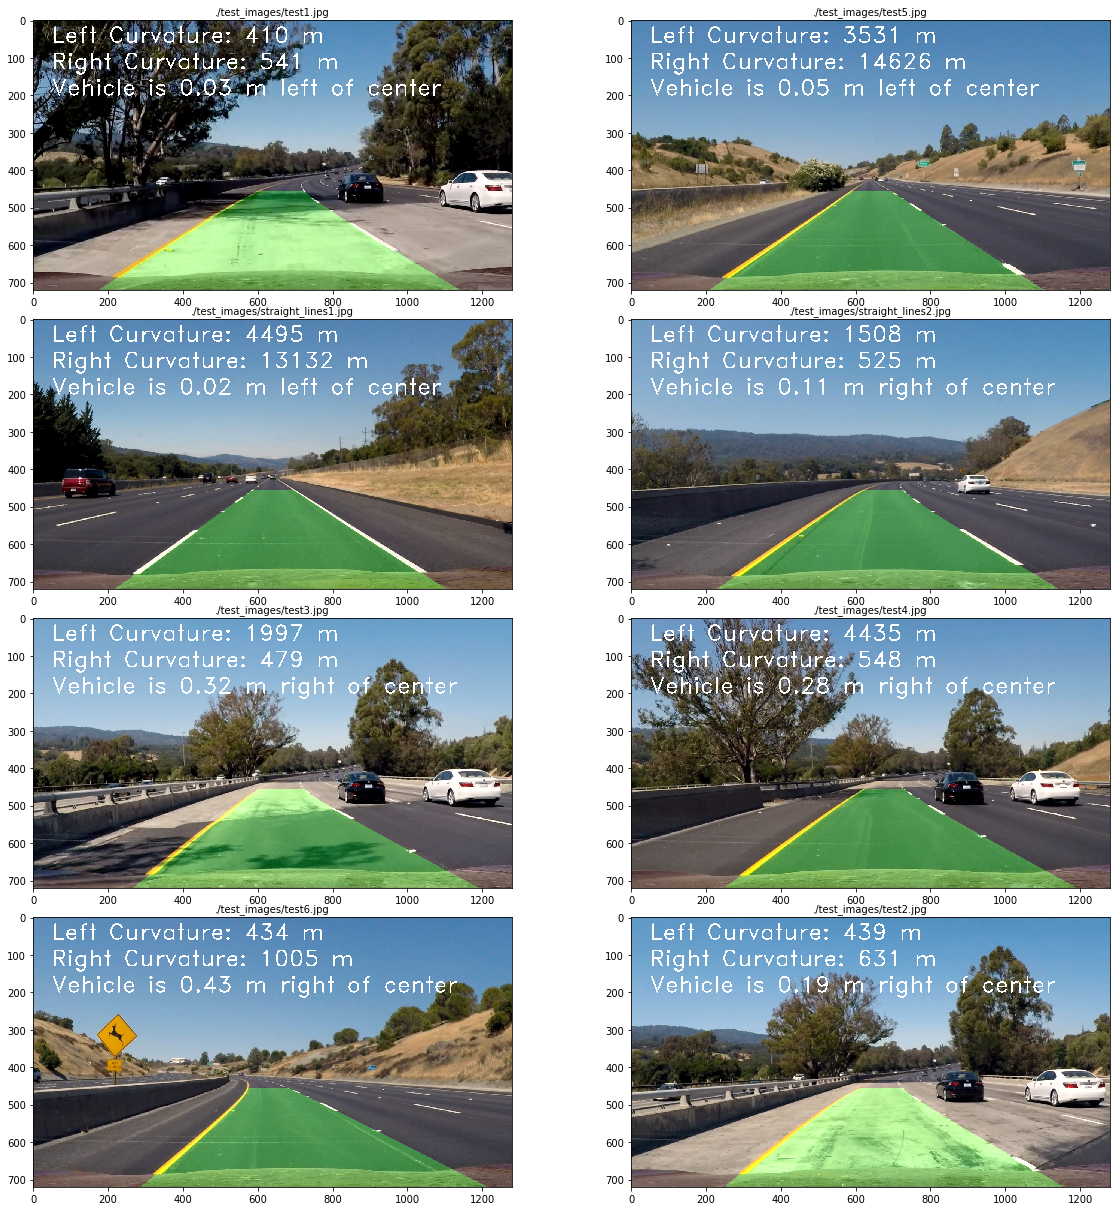

In [20]:
print('Test Images with lane patch and text:')
f, ax = plt.subplots(4, 2, figsize=(16, 18))
#print(ax)
f.tight_layout()
for ax1, idx in zip(ax.flat, range(4*2)):
    out_img = pic_pipeline(test_images[idx])
    plt.imshow(out_img)
    plt.sca(ax1)
    ax1.set_title(fname[idx], fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('./output_images/Display_Images/result_images.jpg')

In [21]:
from moviepy.editor import VideoFileClip

clip1    = VideoFileClip('project_video.mp4')
np_frame = clip1.get_frame(1040/50*2) 
#np_frame = clip1.get_frame(616/50*2) 

In [22]:
from moviepy.editor import VideoFileClip

class Line():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None
        
def video_pipeline(input_video, output_video):
    clip1 = VideoFileClip(input_video)
    
    left_line  = Line()
    right_line = Line()
    
    def process_image(img):
        out_img = pic_pipeline(img)
        return out_img
    
    clip2 = clip1.fl_image(process_image)
    clip2.write_videofile(output_video, audio=False)
    
# Video Output
video_pipeline('project_video.mp4','output_videos/project_video.mp4')

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [04:44<00:00,  4.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

